In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler as srs
import random
import matplotlib.pyplot as plt
from collections import Counter
import csv
import os
import shutil
import pandas as pd
import cv2
import torch.optim as optim
from torch.utils.data import DataLoader

use_cuda = True
import time


In [7]:
dir = '/Users/halle/OneDrive - University of Toronto/Desktop/APS360/Project/APS360_Project/aps360dataset'
transform = transforms.Compose([transforms.ToTensor(),
         transforms.Resize((224, 224)), # images are either 450 * 600 or 1024 * 1024
                                # all resized to 224 * 224 for ResNet
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# transform input images to match requirements; load all images to all_data
all_data = torchvision.datasets.ImageFolder(dir, transform=transform)

In [8]:
all_data

Dataset ImageFolder
    Number of datapoints: 23344
    Root location: /Users/halle/OneDrive - University of Toronto/Desktop/APS360/Project/APS360_Project/aps360dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(224, 224), interpolation=bilinear)
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [9]:
# use a set, random seed
torch.manual_seed(0)

# find 20% of len(all_data) for 20% test and val sets
test_size = int(len(all_data) * 0.004)

# remaining ~60% is left for training
train_size = int(len(all_data) * 0.012)

extra = len(all_data) - 2 * test_size - train_size

In [10]:
# randomly split the data into training, test and validation sets
train_data, val_data, test_data, extra = torch.utils.data.random_split(all_data,
  [train_size, test_size, test_size, extra])

# use Dataloader to allow for iteration (img, label) over a dataset
# same method used in previous labs
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True)

print("There are {0} images in training, ".format(len(train_loader)))
print("{0} images in validation and ".format(len(val_loader)))
print("{0} images in testing".format(len(test_loader)))

There are 280 images in training, 
93 images in validation and 
93 images in testing


In [11]:
def get_counts(loader):
    # information from dataloader
    labels = [label for img, label in loader.dataset]

    # num / class counted
    counts = dict(Counter(labels))

    return counts

train_counts = get_counts(train_loader)
val_counts = get_counts(val_loader)
test_counts = get_counts(test_loader)

In [12]:
original_dataset = train_loader.dataset.dataset

In [13]:
class_names = original_dataset.classes

In [14]:
class_names

['bcc', 'bkl', 'mel', 'nv']

In [15]:
n = {idx: cls for cls, idx in original_dataset.class_to_idx.items()}

In [16]:
n

{0: 'bcc', 1: 'bkl', 2: 'mel', 3: 'nv'}

In [17]:
test_counts

{3: 54, 2: 18, 1: 13, 0: 8}

In [18]:
train_counts.keys()

dict_keys([3, 0, 1, 2])

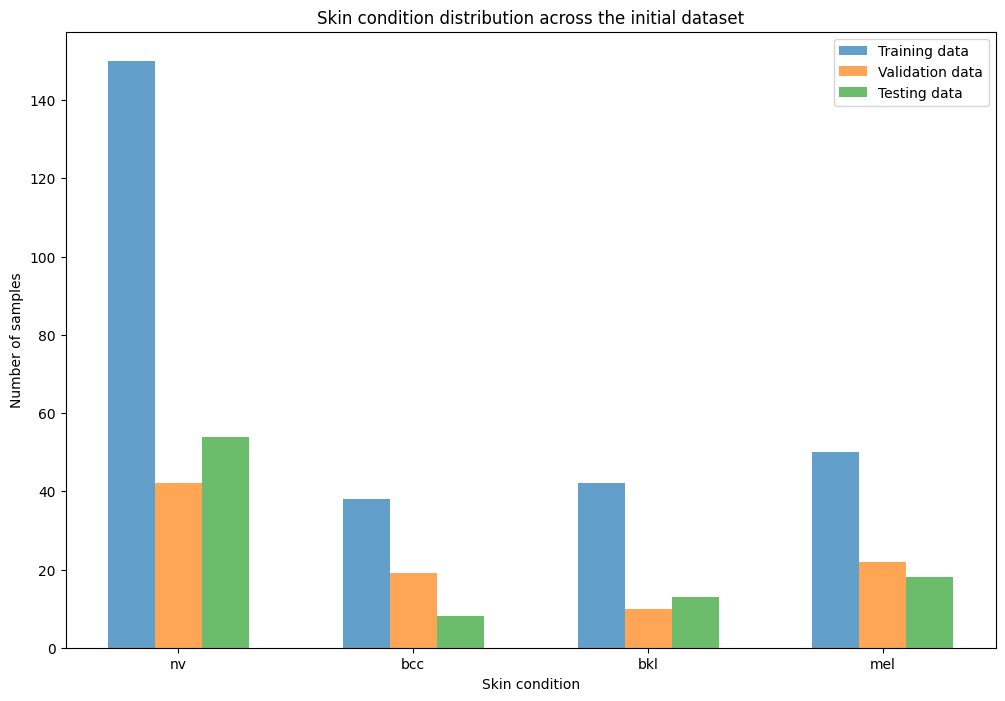

In [19]:
# Pre data augmentation 
labels = ['nv', 'bcc', 'bkl', 'mel']

def plot(train_counts, val_counts, test_counts, title):
    conditions = train_counts.keys()

    train_values = [train_counts.get(c, 0) for c in conditions]
    val_values = [val_counts.get(c, 0) for c in conditions]
    test_values = [test_counts.get(c, 0) for c in conditions]
    
    x = np.arange(len(conditions))
    width = 0.2 
    
    plt.figure(figsize=(12, 8))
    plt.bar(x - width, train_values, width, label='Training data', alpha=0.7)
    plt.bar(x, val_values, width, label='Validation data', alpha=0.7)
    plt.bar(x + width, test_values, width, label='Testing data', alpha=0.7)
    
    plt.xlabel('Skin condition')
    plt.ylabel('Number of samples')
    plt.title(title)
    plt.xticks(x, labels) # can confirm with swapping out conditions here
    plt.legend()
    
    plt.show()


plot(train_counts, val_counts, test_counts, "Skin condition distribution across the initial dataset")


In [20]:
conditions = train_counts.keys()
t_counts = [train_counts.get(c, 0) for c in conditions]
print(f"Training counts: {t_counts}")
v_counts = [val_counts.get(c, 0) for c in conditions]
print(f"Val counts: {v_counts}")
te_counts = [test_counts.get(c, 0) for c in conditions]
print(f"Test counts: {te_counts}")

Training counts: [150, 38, 42, 50]
Val counts: [42, 19, 10, 22]
Test counts: [54, 8, 13, 18]


In [21]:
def augment(data, counts):
    max_count = max(counts)
    augments = [max_count - c for c in counts]

    # transforms for augmentation
    horiz = transforms.RandomHorizontalFlip()
    vert = transforms.RandomVerticalFlip()
    rot = transforms.RandomRotation(90)
    rot_1 = transforms.RandomRotation(270)

    
    augmented_data = []
    all_images = {i: [] for i in range(0, 3)}

    for img, label in data: 
        if label in range(0,3): # minority classes have labels 0, 1, 2
            all_images[label].append((img, label))

    for i in range(0, 3):
        images = all_images[i]
        
        for img, label in images:
            if augments[i + 1] <= 5: # initial class is majority class
                break
            augmented_data.append((horiz(img), label))
            augmented_data.append((vert(img), label))
            augmented_data.append((rot(img), label)) 
            augmented_data.append((rot_1(img), label))
            augments[i + 1] -= 4
            counts[i + 1] += 4
    
    full = data + augmented_data
    return full, counts

In [22]:
aug_test, test_counts = augment(test_data, te_counts)
aug_val, val_counts = augment(val_data, v_counts)
aug_train, train_counts = augment(train_data, t_counts)

In [23]:
train_loader = torch.utils.data.DataLoader(aug_train, shuffle=True)
val_loader = torch.utils.data.DataLoader(aug_val, shuffle=True)
test_loader = torch.utils.data.DataLoader(aug_test, shuffle=True)

In [24]:
# convert list to dict for visualization
def list_to_dict(counts):
    return {0: counts[1], 1: counts[2], 2: counts[3], 3: counts[0]}

test_dict = list_to_dict(test_counts)
val_dict = list_to_dict(val_counts)
train_dict = list_to_dict(train_counts)

In [25]:
train_counts_1 = get_counts(train_loader) # can confirm results with counter
val_counts_1 = get_counts(val_loader)
test_counts_1 = get_counts(test_loader)

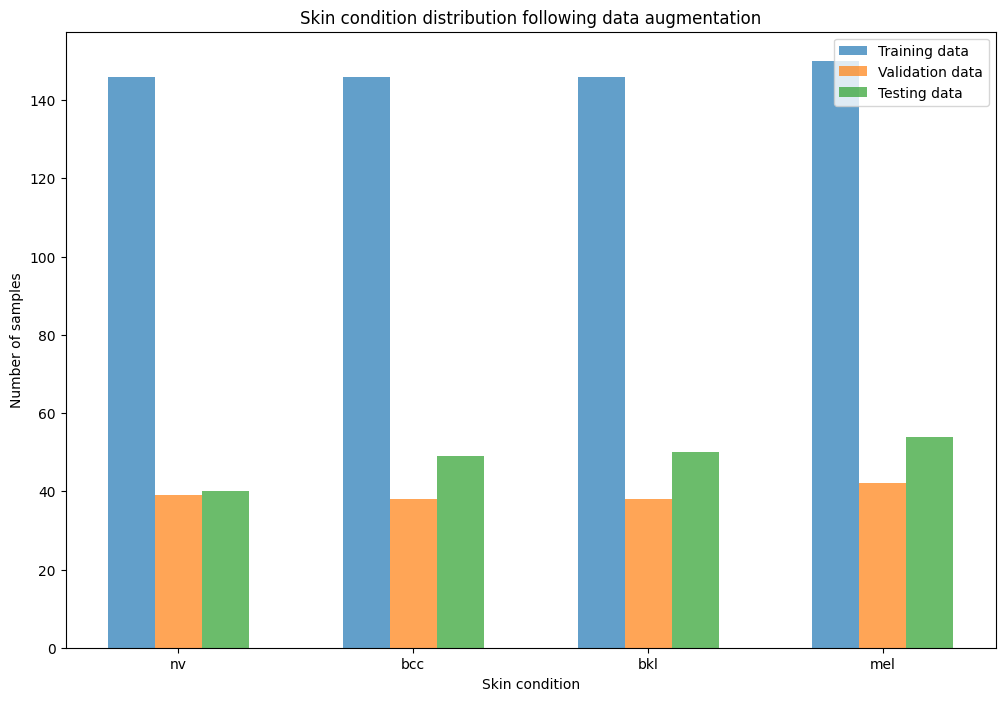

In [54]:
plot(train_dict, val_dict, test_dict, "Skin condition distribution following data augmentation")

# Import data

In [ ]:
# install the official API for Kaggle: https://pypi.org/project/kaggle/
!pip install -q kaggle

In [ ]:
# import the API key from a personal Kaggle account
from google.colab import files
files.upload()

In [ ]:
# make a new directory as specified by the API; move token into that folder
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

# change permissions for the json file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# import the HAM10000 dataset via Kaggle
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# import the isic 2019 dataset from kaggle
#!kaggle datasets download -d andrewmvd/isic-2019

In [ ]:
!unzip skin-cancer-mnist-ham10000.zip

#!unzip isic-2019.zip -d isic-2019

In [ ]:
##### PROCESS HAM10000 IMAGES; ADD INTO FOLDERS BY CLASS #####

# open metadata csv file
with open('HAM10000_metadata.csv','r') as csvfile:
    ham10000_file = csv.reader(csvfile)

    ham10000_meta = []
    for row in ham10000_file:
        ham10000_meta.append(row)

# visualize data
print(ham10000_meta)

In [ ]:
# convert to numpy array
ham10000_arr= np.array(ham10000_meta)

# extract the image IDs column
img_ids = ham10000_arr[1:,1]
print(img_ids)

# extract the corresponding image classes
img_classes = ham10000_arr[1:,2]
print(img_classes)

In [ ]:
# create a new folder for data and navigate to this directory
if not os.path.exists("data"):
  os.makedirs("data")
%cd data

# create a new folder for each class
classes = {'bkl':0, 'mel':0, 'nv':0, 'bcc':0}
for c in classes:
  os.makedirs(c, exist_ok=True)

# return home and move datasets
%cd ..
dataset_folders = ['ham10000_images_part_1', 'ham10000_images_part_2']

# iterate over all images in working directory
for src in dataset_folders:
  for filename in os.listdir(src):
    filename = filename.removesuffix('.jpg')

    # use the extracted image IDs and match to a corresponding class
    if filename in img_ids:
      i = np.where(img_ids == filename)[0][0]
      class_name = img_classes[i]
      if class_name in classes:
        # move image to corresponding class folder
        shutil.move('/content/' + src + '/' + filename + '.jpg',
                    os.path.join('/content/data/' + class_name, filename + '.jpg'))

In [ ]:
# count and print the number of .jpg files in each class folder
for class_name in classes:
    class_folder = os.path.join("data", class_name)
    num_files = len([name for name in os.listdir(class_folder) if name.endswith('.jpg')])
    print(f"Number of .jpg files in {class_name}: {num_files}")

In [ ]:
# remove any extraneous files that are not jpgs
def remove_non_jpg(dir):
    # Iterate over all files in the directory
    for filename in os.listdir(dir):
        path = os.path.join(dir, filename)
        if not filename.lower().endswith('.jpg'):
          if not os.path.isdir(path):
            os.remove(path)

# remove non jpgs from each folder
for c in classes:
  remove_non_jpg("data/" + c)

In [ ]:
# count and print the number of .jpg files in each class folder
for class_name in classes:
    class_folder = os.path.join("data", class_name)
    num_files = len([name for name in os.listdir(class_folder) if name.endswith('.jpg')])
    print(f"Number of .jpg files in {class_name}: {num_files}")

# Preprocessing steps

## Removing corrupted Images

In [ ]:
import os
from PIL import Image

def get_directory_size(directory):
    total_size = 0
    for dirpath, _, filenames in os.walk(directory):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

def remove_corrupted_images(directory):
    initial_size = get_directory_size(directory)
    print(f"Initial directory size: {initial_size / (1024 * 1024):.2f} MB")

    removed_count = 0
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            file_path = os.path.join(root, filename)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verify that it is an image
            except (IOError, SyntaxError) as e:
                print(f'Removing corrupted image: {file_path}')
                os.remove(file_path)
                removed_count += 1

    final_size = get_directory_size(directory)
    print(f"Final directory size: {final_size / (1024 * 1024):.2f} MB")
    print(f"Total images removed: {removed_count}")

# Usage
remove_corrupted_images('/content/data/akiec')



## Noise removal

In [ ]:
# function that takes an image path as input, loads the image, applies the filters and saves the processed image

def remove_noise(image_path, output_path):

  #read the image
  image = cv2.imread(image_path)

  #check if image was successfully loaded
  if image is None:
    print(f"Error: could not read the iamge at {image_path}")
    return

  #apply gaussian blur
  blurred = cv2.GaussianBlur(image, (3,3), 0)
  # 5x5 kernel size and 0 standard deviation

  #apply median filter
  median = cv2.medianBlur(blurred,3)
  # 5x5 kernel size

  #apply bilateral filter
  bilateral = cv2.bilateralFilter(median, 9, 75, 75)
  #9-pixel neighborhood and color space sigmas of 75

  cv2.imwrite(output_path, bilateral)

  print(f"noise removal completed for {image_path}. processed image saved at {output_path}")


In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
input_path = '/content/data/bcc/ISIC_0024331.jpg'
output_path = '/content/processed_image.jpg'

# Check if the input file exists
if not os.path.exists(input_path):
    print(f"Error: The file at {input_path} does not exist.")
else:
    remove_noise(input_path, output_path)

    # Check if the output file was created
    if os.path.exists(output_path):
        print('Original image:')
        original_image = cv2.imread(input_path)
        cv2_imshow(original_image)

        print('Processed image:')
        processed_image = cv2.imread(output_path)
        cv2_imshow(processed_image)
    else:
        print(f"Error: The processed image at {output_path} was not created.")

In [ ]:
plt.imread("/content/data/bcc/ISIC_0024331.jpg")

## Duplicate Images Removal

In [ ]:
%pip install Pillow
%pip install imagededup
%pip install imagehash

In [ ]:
#function to remove duplicate images from the dataset -- NOT TESTED
#expects something like entireDataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Lab3_Gestures_Summer')
#returns cleaned up dataset with all duplicate images removed


import os
from PIL import Image
from imagededup.methods import PHash
import imagehash
from torchvision import datasets, transforms

def removeDuplicateImagesPIL(entireDataset):

  allDuplicateImages = []
  allHashSet = []
  cleanedDataset = []
  pilConvert = transforms.ToPILImage()

  for index, (image, label) in enumerate(entireDataset):
    hash = imagehash.average_hash(pilConvert(image).convert('L') )
    #hash = imagehash.average_hash(transforms.ToPILImage(image))
    if hash in allHashSet:
      allDuplicateImages.append(image)
    else:
      allHashSet.append(hash)

  for i, img in enumerate(entireDataset):
    if img not in allDuplicateImages:
      cleanedDataset.append(img)

  return cleanedDataset


def removeDuplicateImagesImageDedup(entireDataset):
  pHasher = PHash(hash_size=8)
  imagePaths = []
  for image, label in entireDataset:
    imagePaths.append(image)

  encodedImages = pHasher.encode_images(imagePaths)
  duplicateImages = pHasher.find_duplicates(encoding_map = encodedImages, min_similarity_threshold=0.9)
  duplicateImagePaths = set()
  for key, value in duplicateImages.items():
    for image in value:
      duplicateImagePaths.add(image)

  cleanedDataset = []
  for image, label in entireDataset:
    if image not in duplicateImagePaths:
      cleanedDataset.append((image, label))

  return cleanedDataset


In [ ]:
#remove duplicate images
#all_data_cleaned = removeDuplicateImagesPIL(all_data)
#all_data_cleaned = removeDuplicateImagesImageDedup(all_data)

## Hair removal

In [ ]:
import cv2

# algorithm: dull razor technique, described here:
# https://link.springer.com/article/10.1007/s11042-022-13046-0
def hair_removal(img, kernal_size):
  """
  Removes hair from an image using a dull razor technique - applies
  a mask to the original image. Returns a new image with hair removed
  and does not modify the original image.
  """
  # convert to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  # black hat filter
  kernal = cv2.getStructuringElement(1, (kernal_size, kernal_size))
  blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernal)

  # binary thresholding
  ret,mask = cv2.threshold(blackhat, 15, 255, cv2.THRESH_BINARY)

  # apply mask to original image
  dst = cv2.inpaint(img, mask, 3, cv2.INPAINT_TELEA)

  return dst

In [ ]:
img = plt.imread('/content/data/bcc/ISIC_0024403.jpg')
plt.imshow(img)

In [ ]:
new = hair_removal(img, 15)
plt.imshow(new)

# Data visualization

In [4]:
# navigate to the directory with the imported datasets
import os
proj_dir = '/content/data'
os.chdir(proj_dir)

if os.path.exists('.ipynb_checkpoints'):
    !rm -r .ipynb_checkpoints

# use transform to ensure that input image is 224x224 RGB () image as input
transform = transforms.Compose([transforms.ToTensor(),
         transforms.Resize((224, 224)), # images are either 450 * 600 or 1024 * 1024
                                # all resized to 224 * 224 for ResNet
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# transform input images to match requirements; load all images to all_data
all_data = torchvision.datasets.ImageFolder(proj_dir, transform=transform)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/data'

In [ ]:
# preview contents of all data
all_data

In [ ]:
# visualize a single image in the set
image_data = all_data[200][0] # torch.Tensor of shape [3, 224, 224]

# convert to numpy array
image_np = image_data.numpy()

# transpose for matplotlib
image_np = np.transpose(image_np, (1, 2, 0))

# show
plt.imshow(image_np)

In [ ]:
# use a set, random seed
torch.manual_seed(0)

# find 20% of len(all_data) for 20% test and val sets
test_size = int(len(all_data) * 0.2)

# remaining ~60% is left for training
train_size = len(all_data) - 2 * test_size

# randomly split the data into training, test and validation sets
train_data, val_data, test_data = torch.utils.data.random_split(all_data,
  [train_size, test_size, test_size])

# Baseline model (SVM)

SVMs are used for linear / non linear classification, regression and even outlier detection tasks. SVMs are robust to outliers.

They try to find the maximum separating hyperplane (decision boundary) between the different classes. The distance (margin) from it to the nearest data point (support vector) on each side should be maximized.

It is a supervised machine learning algorithm.

The dimension of the hyperplane = number of features - 1

If the data is not linearly separable, it creates a new variable using a kernel. This maps the original input data points into high-dimensional feature spaces.

Steps:

1. Feature Extraction - ensure that the features extracted from the ResNet + CBAM model are compatible with the SVM classifier
2. SVM parameter optimization
3. Evaluation


New Steps:

1. Build and Train ANN for Feature Extraction
2. Extract features using trained ANN
3. Train the SVM on the Extracted Features
4. Evaluate performance of combined model

From our project proposal:

The efficacy of the proposed skin condition classification model will be compared against a support
vector machine (SVM). This baseline model will provide a benchmark to highlight the improvements
brought by the CNN model integrated with CBAM. For the SVM baseline comparison,
instead of passing the features through the final fully connected layer and softmax activation for
classification, they will be fed into an SVM classifier. This SVM will use the extracted features
from the ResNet + CBAM network to classify the skin conditions and cancers. SVM was selected
as the baseline due to its widespread use and proven performance in the classification of skin lesions
(Hameed et al., 2018) and its demonstrated excellence in classification tasks (Chandra & Bedi,
2021).
SVMs are advantageous in terms of simplicity and training speed, especially with smaller datasets.
They find the best possible hyperplane that separates different classes of data points. Despite these
advantages, SVMs may not capture the complex patterns and relationships as effectively as CNNs,
which learn features automatically during the training process. can you help me implement this baseline model


###Build ANN for Feature Extraction


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets

# Define a simple ANN for feature extraction

#the model is used to extract features from the input images. These features are then fed into the SVM classifier
# we do not train it because it s purpose is not to classify or learn from data
class SimpleANN(nn.Module):
    def __init__(self):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(224 * 224 * 3, 512)  # Input size 224x224x3, output size 512
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 128)  # Hidden layer with output size 128
        self.fc3 = nn.Linear(128, 4)  # Output layer for 4 classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [27]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

280
93
93


In [28]:
# Define your data loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [29]:
baselineModel = SimpleANN()

### Extract features using trained ANN

In [31]:
#importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# Confusion Matrix
import os

In [34]:
def extract_features(loader, model):
    features_list = []
    labels_list = []

    model.eval()

    for images, labels in loader:
        with torch.no_grad():
            features = model(images)
            features_list.append(features.cpu().numpy())  # Append the numpy array of features
            labels_list.append(labels.numpy())  # Append labels as numpy array

    # Concatenate all features and labels
    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

    return features_array, labels_array

In [35]:
# extract features for train, validation, and test sets
X_train, Y_train = extract_features(train_loader, baselineModel)
X_val, Y_val = extract_features(val_loader, baselineModel)
X_test, Y_test = extract_features(test_loader, baselineModel)

# print extracted feature shapes
print(f"Train features shape: {X_train.shape}")
print(f"Train labels shape: {Y_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Validation labels shape: {Y_val.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Test labels shape: {Y_test.shape}")

Train features shape: (280, 4)
Train labels shape: (280,)
Validation features shape: (93, 4)
Validation labels shape: (93,)
Test features shape: (93, 4)
Test labels shape: (93,)


### Train the SVM on the Extracted Features

In [37]:
def train_svm(X_train, Y_train, X_test, Y_test):
  #initialize the SVM with linear kernel and regularization parameter C
  svm_classifier = SVC(kernel='linear', class_weight='balanced', C=1.0)
  #train the SVM classifier
  svm_classifier.fit(X_train, Y_train)

  #predict the labels for the test data
  y_pred = svm_classifier.predict(X_test)

  #compute the accuracy of the classifier
  accuracy = accuracy_score(Y_test, y_pred)
  print(f"SVM Accuracy: {accuracy * 100:.2f}%")

  print(classification_report(Y_test, y_pred))

  # Confusion Matrix
  conf_matrix = confusion_matrix(Y_test, y_pred)
  print("Confusion Matrix:")
  print(conf_matrix)

  # Precision, Recall, F1-score for each class
  precision = precision_score(Y_test, y_pred, average=None)
  recall = recall_score(Y_test, y_pred, average=None)
  f1 = f1_score(Y_test, y_pred, average=None)

  print("Precision:")
  print(precision)

  print("Recall:")
  print(recall)

  print("F1-score:")
  print(f1)

  return svm_classifier, accuracy, conf_matrix, precision, recall, f1

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = ['bcc', 'bkl', 'mel', 'nv']

# plotting the Confusion Matrix
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# plotting Precision, Recall, and F1-score
def plot_metrics(precision, recall, f1):
    metrics = np.array([precision, recall, f1])
    metrics_names = ['Precision', 'Recall', 'F1-score']

    plt.figure(figsize=(12, 4))

    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i + 1)
        plt.bar(class_labels, metric, color='skyblue')
        plt.xlabel('Classes')
        plt.ylabel(metrics_names[i])
        plt.title(f'{metrics_names[i]} for each class')

    plt.tight_layout()
    plt.show()

###Evaluate performance of combined model

SVM Accuracy: 13.98%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.14      1.00      0.25        13
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        54

    accuracy                           0.14        93
   macro avg       0.03      0.25      0.06        93
weighted avg       0.02      0.14      0.03        93

Confusion Matrix:
[[ 0  8  0  0]
 [ 0 13  0  0]
 [ 0 18  0  0]
 [ 0 54  0  0]]
Precision:
[0.         0.13978495 0.         0.        ]
Recall:
[0. 1. 0. 0.]
F1-score:
[0.         0.24528302 0.         0.        ]


C:\Users\halle\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\halle\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\halle\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

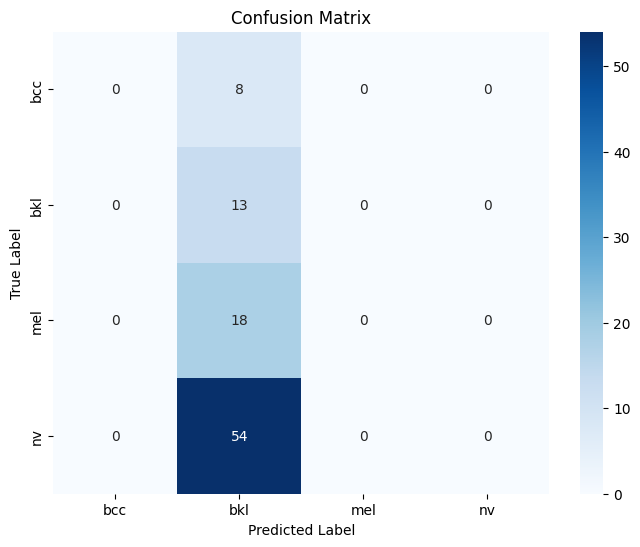

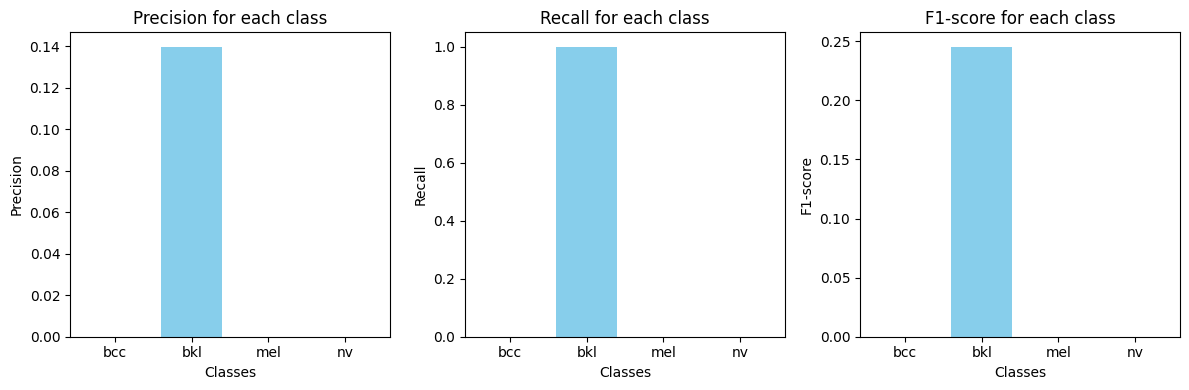

In [39]:
# Train SVM classifier and get accuracy
svm_classifier, accuracy, conf_matrix, precision, recall, f1 = train_svm(X_train, Y_train, X_test, Y_test)

plot_confusion_matrix(conf_matrix)
plot_metrics(precision, recall, f1)

Overall Performance Analysis:

1. accuracy:
- the svm classifier achieved an accuracy of 40.46%. This means that out of all the test samples, approximately 40.46% were correctly classified by the model.

2. precision, recall and f1 score:
- precision indicates how many of the predicted positive samples are actually positive
- recall indicates how many of the actual positive samples were correctly identified by the model
- f1-score is the harmonic mean of precision and recall

3. class-wise analysis
- class 0:
  - precision = 0.13
  - recall = 0.47
  - f1-score = 0.20
- class 1:
  - precision = 0.19
  - recall = 0.48
  - f1-score = 0.27
  The model has low precision but relatively high recall for classes 0 and 1, indicating it predicts many false positive but captures a significant portion of acutal positives.
- class 2:
  - precision = 0.27
  - recall = 0.24
  - f1-score = 0.25
  Low precision and recall indicating struggles with this class.
- class 3:
  - precision = 0.81
  - recall = 0.41
  - f1-score = 0.55
  This class has high precision and lower recall, meaning it accurately predicts positive samples but misses many actual positives.

4. confusion matrix
- The confusion matrix shows the distribution of predictions for each class. For example, for class 0, there were 58 true positives, 40 instances misclassified as class 1, 2 as class 2, and 23 as class 3.


